# Utilities

Overview:

1. Integrals.
3. Checkpointing.
4. Generating XDMF files.

**Keywords:** checkpointing, utilities, volume integrals, surface integrals, xdmf



In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

## Integrals

The `Integral` class constructs the volume integral

$$
F_{i}  =   \int_V \, f_i(\mathbf{x}) \, \mathrm{d} V  
$$

for some function $f_i$ (specified by a `Function` object), over some domain $V$ (specified by an `FeMesh` object), or the surface integral

$$
F_{i}  =   \oint_{\Gamma} \,  f_i(\mathbf{x})  \,  \mathrm{d}\Gamma  
$$

for some surface $\Gamma$ (specified via an `IndexSet` object on the mesh). 

In the following example, we will calculate a root mean square velocity defined as:
$$
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) \, \mathrm{d}V } {\int_V \, \mathrm{d}V} }
$$



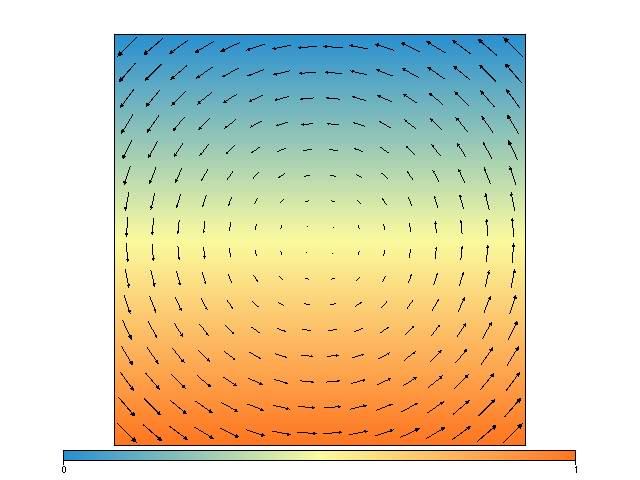

In [2]:
# setup required objects
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))
temperatureField = uw.mesh.MeshVariable( mesh, 1 )
velocityField    = uw.mesh.MeshVariable( mesh, 2 )

# init
temperatureField.data[:,0] = -mesh.data[:,1]/2. + 0.5
velocityField.data[:,0] =  -mesh.data[:,1]
velocityField.data[:,1] =   mesh.data[:,0]

# viz
fig1 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.1) )
fig1.append( glucifer.objects.Surface( mesh, temperatureField ) )
fig1.show()

In [3]:
# define required function
vdotv = fn.math.dot( velocityField, velocityField )

# create integral objects, passing in functions
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

# evaluate integrals
v2sum  = v2sum_integral.evaluate()
volume = volume_integral.evaluate()

# finally, calculate RMS
v_rms  = math.sqrt( v2sum[0] )/volume[0]
print('RMS velocity = {0:.3f}'.format(v_rms))

RMS velocity = 0.408


To evaluate an integral over a subdomain the ``fn.branching.conditional`` class may be useful:

In [4]:
# create circle function
radius = 1.
coord    = fn.coord() 
fn_sphere = fn.math.dot( coord, coord ) < radius**2

# setup a function that is 1 if the coordinates, are inside the circle, and zero otherwise.
conditions     = [ ( fn_sphere , 1.0), 
                   ( True      , 0.0) ]
kernelFunction = fn.branching.conditional( conditions )

# create and evaluate integral
volume_integral = uw.utils.Integral( mesh=mesh, fn=kernelFunction )
volume          = volume_integral.evaluate()
print('Area from integral = {0:6.8e}'.format(volume[0]))

Area from integral = 3.14559221e+00


In the following example, we will calculate the Nusselt number defined by

$$
Nu = -h \frac{ \oint_{\Gamma_{t}} \partial_z T (\mathbf{x}) \, \mathrm{d}\Gamma}{ \int_{\Gamma_{b}} T (\mathbf{x}) \,  \mathrm{d}\Gamma}
$$

where $h$ is the height of the domain, and $\Gamma_t$ and $\Gamma_b$ are the top and bottom surfaces respectively.


In [5]:
nuTop    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuBottom = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Once again we activate these integrals using the ``evaluate`` function.

In [6]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 0.500000


Checkpointing 
-----
Checkpointing is the process of saving sufficient data to facilitate restarting your simulations at a later stage. Note that we do not provide explicit checkpointing functionality, but instead provide the tools required for the loading and saving of heavy data. Which data items are required for restart will depend on the systems you have used and how you have constructed your models.

The following Underworld data structures have load/save functionality: 
 * `SwarmVariables` 
 * `Swarm`
 * `MeshVariables`
 * `Mesh`

All files are saved in HDF5 format.

*Note*: When saving a `SwarmVariable`, if you wish to reload the `SwarmVariable` data at a later stage, you must also save the `Swarm` for the corresponding state (generally, the same timestep). This requirement is due to the population control mechanisms swarms generally used for swarms, and also due to particles crossing process boundaries. When you come to reload the `Swarm` and `SwarmVariable`, you must load the `Swarm` **first**. Note again that the `Swarm` and `SwarmVariable` must be of corresponding state for successful reload.


In [7]:
outputPath = 'checkpointing/'
# Make output directory if necessary
import os
if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

**SwarmVariable**

Below a `Swarm` and a `SwarmVariable`, are created and saved to disk, then a new swarm loads the data from disk.


* Save the swarm data to disk using the `save()` method on the `Swarm` and `SwarmVariable` objects.  
   Note the handle object that is returned from the `save()` method. This is currently used for `xdmf()` operation, see below.
* Load the swarm data from disk using the `load()` method on the `Swarm` and `SwarmVariable` objects


In [8]:
swarm1    = uw.swarm.Swarm(mesh)
swarm1var = swarm1.add_variable(dataType='int', count=1)
layout    = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm1,particlesPerCell=5)
swarm1.populate_using_layout(layout)

In [9]:
# evaluate kernalFunction for each particle in swarm1, record result in swarmvar1
swarm1var.data[:] = kernelFunction.evaluate(swarm1.particleCoordinates.data)


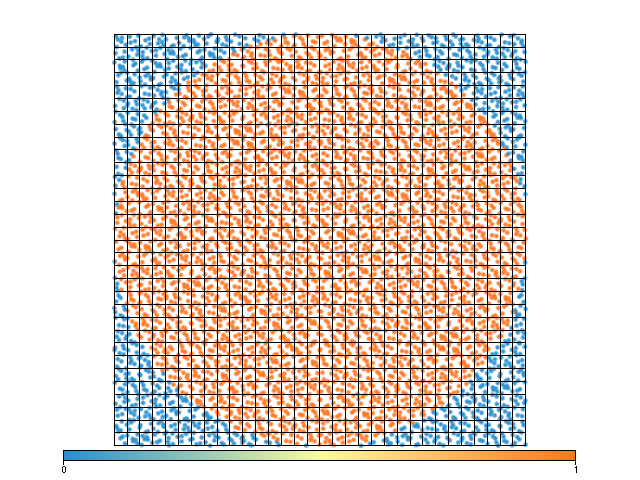

In [10]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Mesh(mesh) )
fig.append( glucifer.objects.Points(swarm1, fn_colour=swarm1var, pointSize=6.0 ) )
fig.show()

In [11]:
s1Hnd  = swarm1.save(outputPath+'swarm.h5')
s1vHnd = swarm1var.save(outputPath+'swarmvar.h5')

# new swarm
swarm2    = uw.swarm.Swarm(mesh)
swarm2var = swarm2.add_variable(dataType='int', count=1)
swarm2.load(outputPath+'swarm.h5')
swarm2var.load(outputPath+'swarmvar.h5')

In [12]:
import numpy as np
print "Are the swarm variables close? ...", np.allclose( swarm2var.data[:], swarm1var.data[:] )
print "Are the swarm particle coordinates close? ... ", np.allclose( swarm2.particleCoordinates.data[:], swarm1.particleCoordinates.data[:])

Are the swarm variables close? ... True
Are the swarm particle coordinates close? ...  True


** MeshVariables **

The `MeshVariable` object behaves similarly to `SwarmVariable` object with the `save()` and `load()` functionality.

In [13]:
mHnd   = mesh.save(outputPath+'mesh.h5')
velHnd = velocityField.save(outputPath+'velocity.h5', outputPath+'mesh.h5')

newField = uw.mesh.MeshVariable(mesh, nodeDofCount=velocityField.nodeDofCount )
newField.load(outputPath+'velocity.h5')

print "Are the mesh variables close ? ...", np.allclose( newField.data, velocityField.data )

Are the mesh variables close ? ... True


Writing to XDMF files
-----
The `XDMF` file format brings together *data* and *geometric* information in a format the can be viewed with [ParaView](http://www.paraview.org/).  
The handlers that were returned after the `save()` operations above specify this information in hdf5 format. 
 * *data* as `MeshVariable` and `SwarmVariable`
 * *geometric* as the `Mesh` and `Swarm`
 
The handlers are passed to Underworld's `XDMF` methods, along with textual names to give the Variable in the .xdmf file.


In [14]:
velocityField.xdmf(outputPath+'velocity.xdmf', velHnd, "MyField", mHnd, "TheMesh", modeltime=0.0)
swarm1var.xdmf(outputPath+'swarmvar.xdmf', s1vHnd, "SwarmVariable", s1Hnd, "TheSwarm", modeltime=0.1)


**Write XDMF file**

For more details on using XDMF write and to see it in a dynamical simulation context, see the example **1_06_Rayleigh_Taylor**.

In [15]:
if uw.rank() == 0:
    import os
    if os.path.exists(outputPath):
        os.remove(outputPath+'mesh.h5')
        os.remove(outputPath+'velocity.h5')
        os.remove(outputPath+'swarm.h5')
        os.remove(outputPath+'swarmvar.h5')
        os.remove(outputPath+'velocity.xdmf')
        os.remove(outputPath+'swarmvar.xdmf')
        os.rmdir(outputPath)